<a href="https://colab.research.google.com/github/salma-abed/Deep-learning-based-automated-detection-and-classification-of-Alzheimer-s-disease-Using-Neuroimaging/blob/main/VGG16_latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import nibabel as nib
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from shutil import copyfile
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from tensorflow import keras
import pandas as pd
from google.colab import drive
import shutil
import tensorflow as tf

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path = '/content/drive/MyDrive/output_images_preprocessed'
train_path = '/content/drive/MyDrive/output_images_preprocessed/train'
test_path = '/content/drive/MyDrive/output_images_preprocessed/test'
label_names = ['AD', 'CN', 'LMCI', 'MCI']

In [ ]:
class VGG16Model:
    def __init__(self, train_path, test_path, label_names, train_data=None, test_data=None):
        # Initialize the object's data members
        self.train_path = train_path
        self.test_path = test_path
        self.label_names = label_names
        self.train_data = train_data
        self.test_data = test_data
        self.model = None
        
    def build_model(self):
        # Define the VGG16 model architecture
        self.model = tf.keras.applications.VGG16(
            include_top=True,    # whether to include the fully connected layer on top of the network
            weights=None,        # use random initialization for the weights
            input_shape=(224, 224, 3),   # specify the shape of the input image tensor
            classes=len(self.label_names)  # specify the number of output classes
        )
        
    def prepare_data(self):
        # Define the data generators for training and testing
        train_datagen = ImageDataGenerator(rescale=1.0 / 255)    # rescale pixel values to [0, 1] for training data
        test_datagen = ImageDataGenerator(rescale=1.0 / 255)     # rescale pixel values to [0, 1] for testing data
        
        # Set up the training data generator
        train_generator = train_datagen.flow_from_directory(
            directory=self.train_path,           # directory containing the training data
            classes=self.label_names,            # list of label names for the dataset
            batch_size=32,                       # batch size for training
            shuffle=True,                        # shuffle the training data after each epoch
            seed=42,                             # set the random seed for shuffling the training data
            target_size=(224, 224),              # resize input images to 224x224 pixels
        )
        
        # Set up the testing data generator
        test_generator = test_datagen.flow_from_directory(
            directory=self.test_path,            # directory containing the testing data
            classes=self.label_names,            # list of label names for the dataset
            batch_size=32,                       # batch size for testing
            shuffle=True,                        # shuffle the testing data after each epoch
            seed=42,                             # set the random seed for shuffling the testing data
            target_size=(224, 224),              # resize input images to 224x224 pixels
        )
        
        # Assign the data generators to the training and testing sets
        self.train_data = train_generator
        self.test_data = test_generator
        
    def train_model(self, epochs=10, optimizer='adam'):
        # Compile the model with an optimizer, loss function, and evaluation metric
        self.model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        
        # Train the model using the training data generator





        
        self.model.fit(self.train_data, epochs=epochs)
        
    def evaluate_model(self):
        # Evaluate the model on the testing data generator
        loss, acc = self.model.evaluate(self.test_data)
        print(f"Test accuracy: {acc:.2f}")
        
    def predict(self, image_path):
        # Load the image from the specified file path and resize it to 224x224 pixels
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
        
        # Convert the image to a numpy array and add a batch dimension
        img_array = tf.keras.preprocessing.image.img_to_array(img)
    def display_summary(self):
      if self.model is None:
          print("Model has not been built yet. Please call build_model() first.")
      else:
          vgg16_model = tf.keras.applications.VGG16(
              include_top=True,
              weights=None,
              input_shape=(224, 224, 3),
              classes=len(self.label_names)
          )
          vgg16_model.summary()


In [ ]:
# Create an instance of the ResNet50Model class
model = VGG16Model(train_path=train_path, test_path=test_path, label_names=label_names)

# Build the model architecture
model.build_model()

# Prepare the data generators
model.prepare_data()

Found 3170 images belonging to 4 classes.
Found 800 images belonging to 4 classes.


In [ ]:
model.display_summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Train the model
model.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.model.fit(model.train_data, epochs=15)

Epoch 1/15
100/100 [==============================] - 1580s 16s/step - loss: 1.3949 - accuracy: 0.2489
Epoch 2/15
100/100 [==============================] - 40s 401ms/step - loss: 1.3865 - accuracy: 0.2467
Epoch 3/15
100/100 [==============================] - 39s 393ms/step - loss: 1.3864 - accuracy: 0.2353
Epoch 4/15
100/100 [==============================] - 40s 397ms/step - loss: 1.3863 - accuracy: 0.2397
Epoch 5/15
100/100 [==============================] - 40s 395ms/step - loss: 1.3864 - accuracy: 0.2416
Epoch 6/15
100/100 [==============================] - 40s 395ms/step - loss: 1.3863 - accuracy: 0.2401
Epoch 7/15
100/100 [==============================] - 40s 395ms/step - loss: 1.3864 - accuracy: 0.2476
Epoch 8/15
100/100 [==============================] - 40s 395ms/step - loss: 1.3863 - accuracy: 0.2483
Epoch 9/15
100/100 [==============================] - 40s 395ms/step - loss: 1.3863 - accuracy: 0.2476
Epoch 10/15
100/100 [==============================] - 40s 396ms/step - l

In [ ]:
model.evaluate_model()

25/25 [==============================] - 371s 15s/step - loss: 1.3863 - accuracy: 0.2500
Test accuracy: 0.25


25/25 [==============================] - 3s 116ms/step


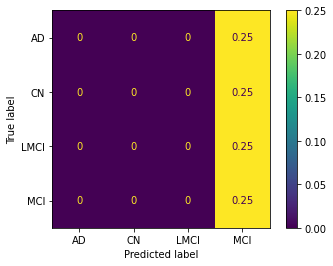

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Get predicted labels
y_pred_probs = model.model.predict(model.test_data)
y_pred = np.argmax(y_pred_probs, axis=1)
labels = ["AD", "CN", "LMCI","MCI"]
y_test = model.test_data.labels
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix= result, display_labels= labels)
disp.plot()